In [3]:
%matplotlib inline  
import numpy as np 
import pandas as pd 
import pylab as pl 
import datetime as dt 
import os 
from wmf import wmf 
from multiprocessing import Pool
import matplotlib
from cpr import cpr
import pickle
import alarmas as al
#Ignorar avisos pendejos
import warnings
warnings.filterwarnings('ignore')

In [4]:
rutaconfig='/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/configfile_web.md'
listconfig=al.get_rutesList(rutaconfig)
dfconfig=pd.read_json(al.get_ruta(listconfig,'ruta_JSONinfosirenas'))
dfconfig

,EstMeteoAdentro,EstMeteoAfuera,EstN30m,EstNivel,EstNivel1,EstPluvioAdentro,EstPluvioAfuera,EstTto,Nombres Alarmas,Nombres Corriente Asociada,URL Cuencas
216,[197],[249],[108],"[90, 108]",[108],"[3, 18, 43]",,,SIRENA SANTA RITA SAN ANTONIO DE PRADO,Q. DONA MARIA,NaN
219,,[249],,"[173, 116]",[173],[29],"[1, 8]",,SIRENA BELEN - LAS VIOLETAS,Q. LA PICACHA,NaN
220,,[249],,"[173, 116]",[116],[29],"[1, 8, 9]",,SIRENA AGUAS FRIAS,Q. PICACHA,NaN
221,,[105],,[259],[259],,"[33, 253]",,SIRENA ANDALUCIA CALDAS,Q. LA CORRALA,NaN
222,,[82],,"[251, 186]",[186],,"[234, 30]",,SIRENA BARBOSA,Q. LA GALLINAZA,NaN
223,,,,"[265, 135]",[135],,"[12, 14, 48, 89]",,SIRENA BELLO CAFETAL,Q. LA LOCA,NaN
224,[105],,"[179, 106]","[179, 106, 124]",[106],"[267, 61, 261, 33, 253]",,[179],SIRENA LA ESTRELLA,RIO MEDELLIN - LA INMACULADA,NaN
226,,[105],,[246],[246],[261],[61],,SIRENA LA RAYA,Q. LA RAYA,NaN
279,,[70],,[239],[239],[248],[70],,SIRENA PIEDRAS BLANCAS,PIEDRAS BLANCAS,NaN
280,,,,"[283, 134]",[134],"[281, 121]","[89, 14, 48]",,SIRENA LA ISLA,LA MADERA Y MONTANITA,NaN


Funciones

In [2]:
def FindMax(Q,fechas,umbral,horasAtras=12,BusquedaAdelante=36):
    '''Nota: Q debe ser un masked_array'''
    pos=np.where(Q>umbral)[0]
    grupos=[];g=[];Qmax=[]
    #Encuentra el maximo de cada grupo
    for pant,pnext in zip(pos[:-1],pos[1:]):        
        if pant+1>=pnext and pant+BusquedaAdelante>=pnext:
            g.append(pant)
        else:
            if len(g)>0:
                PosMaxGrupo=np.argmax(Q[g])
                grupos.append(g[PosMaxGrupo])
                Qmax.append(np.max(Q[g]))
            g=[]
    #Pule el maximo por si hay noData
    for c,g in enumerate(grupos):
        if Q.mask[g-1]:
            grupos.pop(c)
    #Obtiene las fechas 12 horas atras 
    if type(fechas)==list:
        fechas=__np.array(fechas)
    FechasAtras=fechas[grupos]-dt.timedelta(hours=horasAtras)
    fechas=list(fechas)     
    posAtras=[fechas.index(i) for i in FechasAtras]
    return grupos,np.array(Qmax)

#### Se carga información.

In [3]:
#cuenca .nc
cu= wmf.SimuBasin(rute='/media/nicolas/Home/Jupyter/Soraya/git/Academia/Art-Lluvia/data/cuencaAMVA_v03.nc')
#datos pluvio histórico
dfpluvioH=pd.read_msgpack('/media/nicolas/Home/Jupyter/Soraya/git/Academia/Art-Lluvia/data/pluvioCPR_2013-01-01_2018-01-01_5min.msg')
#datos nivel
N=pd.read_msgpack('/media/nicolas/Home/Jupyter/Soraya/git/Academia/Art-Lluvia/data/Qobs99_5min_2013-01-01_2017-12-31.msg')

Búsqueda de eventos - HISTORIA

In [4]:
#Busqueda de maximos 
Ni=N/100.0
Nima = np.ma.array(Ni.values, mask=Ni.values > 1000)
G, Nimax = FindMax(Nima, Ni.index.to_pydatetime(), 1, BusquedaAdelante=100)
#Maximos establecidos como series de pandas
Gs_ni = pd.Series(Nima[G], index=Ni.index[G])
Gs_ni.size

263

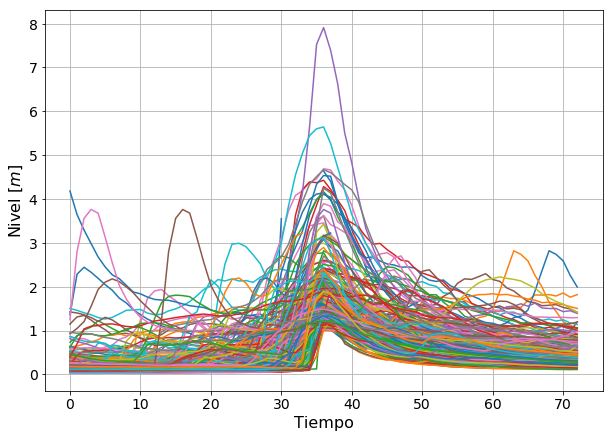

In [6]:
#se plotean y guardan los eventos.
tm = pd.Timedelta('3 hours')
fig = pl.figure(figsize=(10,7))
ax = fig.add_subplot(111)
Matriz=[]
for p,i in enumerate(Gs_ni.index):
    ax.plot(Ni[i - tm: i + tm].values)
    Matriz.append(Ni[i - tm: i + tm].values)
pl.grid()
pl.xlabel('Tiempo', size = 16)
pl.ylabel('Nivel $[m]$', size = 16)
ax.tick_params(labelsize = 14)

### Nivel

Consulta últimas 3 horas N

In [7]:
self= cpr.Nivel(99)
start=(dt.datetime.now()-pd.Timedelta('3 hours')).strftime('%Y-%m-%d-%H:%M')
end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')
level=self.get_level(start,end)
level=(level['nivel'].resample('5T').mean()/100.0)

Estadistico

In [8]:
code=99
res_estadistico='/media/nicolas/Home/Jupyter/Esneider/modelo_crecidas/pronostico_niveles.bin'
#ESTADISTICO
# se lee la info del pronostico 30m
f=open(res_estadistico)
n_pronos=pickle.load(f)
f.close()

n_pronos=pd.DataFrame(n_pronos)

#si la estacion tiene modelo estadistico
if float(code) in map(int,n_pronos[0]):
    columns=['codigo','n30p25','n30p50','n30p75','Ttop25','Ttop50','Ttop75']
    n_pronos.columns=columns
    n_pronos['codigo']=map(int,n_pronos['codigo'])
    n_pronos.index=n_pronos['codigo']
#         n_pronos.index.name=''
    n_pronos=n_pronos.drop('codigo',axis=1)
    n_pronos=n_pronos.T

#         if n_pronos[code].all() == 0:
    if n_pronos[code].all() != 0:
        pass
    else:
        #n30m
#             na=n_pronos[code]['n30p25'];nb=n_pronos[code]['n30p50'];nc=n_pronos[code]['n30p75']
        na=250;nb=300;nc=350
        #tto
#             ta=n_pronos[code]['Ttop25'];tb=n_pronos[code]['Ttop50'];tc=n_pronos[code]['Ttop75']
        ta=20;tb=30;tc=40


#### Qobs vs. frecuencia de los Qmax.

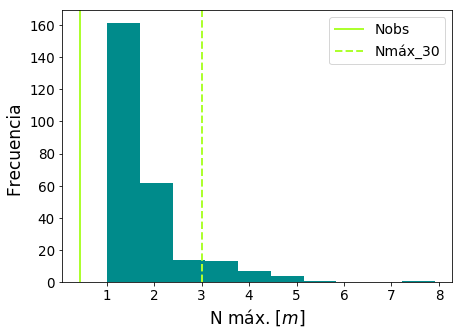

In [9]:
fig=pl.figure(figsize=(7,5))
ax=fig.add_subplot(111)
pl.hist(Gs_ni,color='darkcyan')
pl.axvline(level[-1],c='greenyellow',lw=2,label='Nobs')
pl.axvline(nb/100.0,c='greenyellow',lw=2,label=u'Nmáx_30',ls='--')
ax.set_ylabel('Frecuencia ', size= 17)
ax.set_xlabel(u'N máx. $[m]$', size= 17)
ax.tick_params(labelsize=13.5)
ax.legend(fontsize=14)


#### Forma de hidrógrafa.

In [10]:
#Matriz
Matriz=pd.DataFrame(Matriz)
P1=Matriz.quantile(0.01)
P25=Matriz.quantile(0.25)
Median=Matriz.quantile(0.5)
P75=Matriz.quantile(0.75)
P99=Matriz.quantile(0.99)


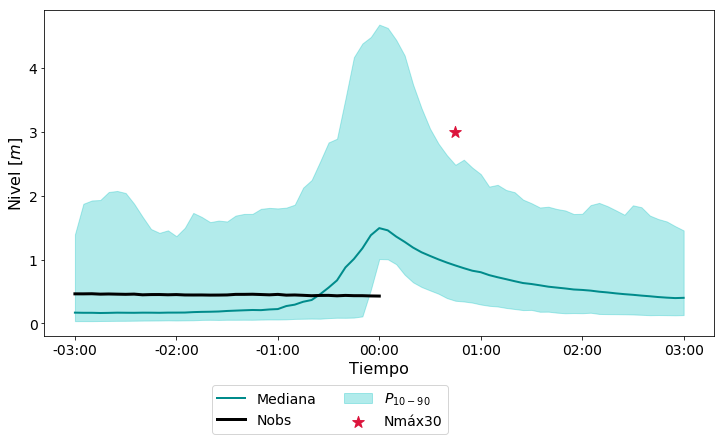

In [13]:
# label time
hours=np.arange(-3,4)
rng1=[]
for i in range(hours.size):
    if hours[i]<0:
        rng1.append('-0'+str(np.abs(hours[i]))+':00')
    else:
        rng1.append('0'+str(np.abs(hours[i]))+':00')
rng1=np.array(rng1)
#plot
fig=pl.figure(figsize=(12,6))
ax=fig.add_subplot(111)
# pl.plot(mean,color='k',label='Media')
# for p,i in enumerate(Gs_ni.index):
#     ax.plot(Ni[i - tm: i + tm].values, color='lightgray')


# ax.plot(P1,color='darkcyan',label='$P_{1}$',ls='--',lw=2)
# ax.plot(P99,color='darkcyan',label='$P_{99}$',ls='--',lw=2)
ax.fill_between(np.arange(P1.size),P1,P99, color = 'c', alpha = 0.3,label='$P_{10-90}$')
ax.plot(Median,color='darkcyan',label='Mediana',lw=2) #'yeloowgreen.
ax.plot(level.values,c='k',lw=3,label='Nobs')
# ax.axvline(36,0,10,color='k',ls='--')
pl.scatter(45,nb/100.0,c='crimson',marker='*',s=150,label=u'Nmáx30')
ax.set_ylabel('Nivel $[m]$', size= 16)
ax.set_xlabel('Tiempo', size= 16)
ax.tick_params(labelsize=14)
ax.set_xticks(np.arange(0,73,12))
ax.set_xticklabels(rng1)
# ax.grid()
ax.legend(fontsize=14,loc=(0.25,-0.30),ncol=2)

### Pluvio

Consulta pluvio últimas 3 horas.

In [144]:
#dentro de la cuenca
ests=np.array([  1,   2,   3,   5,   8,   9,  10,  11,  12,  15,  17,  18,  19,
        20,  21,  22,  23,  26,  27,  28,  29,  33,  34,  35,  36,  38,
        39,  41,  43,  44,  45,  46,  49,  50,  52,  53,  54,  56,  57,
        58,  60,  61,  62,  64,  65,  67,  71,  81, 129, 146, 171, 184,
       189, 193, 211, 230, 244, 253, 261, 263, 266, 267])

In [251]:
start=(dt.datetime.now()-pd.Timedelta('10 days')).strftime('%Y-%m-%d-%H:%M')
end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')

#contador de tiempo
print dt.datetime.now()

listpluvio2=[]
for i in ests:
    try:
        self = cpr.Pluvio(i)
        seriep = self.read_pluvio(start,end)
        listpluvio2.append(seriep) 
    except:
        pass
listpluvio2.append(seriep.index)

#contador de tiempo
print dt.datetime.now()

2018-03-20 18:08:17.049991
2018-03-20 18:11:24.236388


In [252]:
pluvio=np.array(listpluvio2)
dfpluvio=pd.DataFrame(pluvio.T)
dfpluvio.index=dfpluvio[dfpluvio.keys()[-1]]
dfpluvio=dfpluvio.drop(dfpluvio.keys()[-1],axis=1)
dfpluvio.index.name=''
dfpluvio.columns=map(str,ests)
dfpluvio=dfpluvio.resample('5T').sum()

In [253]:
dfpluvio

,1,2,3,5,8,9,10,11,12,15,...,189,193,211,230,244,253,261,263,266,267
,,,,,,,,,,,,,,,,,,,,,
2018-03-10 18:05:00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-03-10 18:10:00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-03-10 18:15:00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-03-10 18:20:00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-03-10 18:25:00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-03-10 18:30:00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-03-10 18:35:00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-03-10 18:40:00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018-03-10 18:45:00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Forecast pluvio

In [264]:
res_pluvioforecast='/media/nicolas/Home/Jupyter/Esneider/Lluvia_operacional/Salidas/'
est_pluvio=map(str,[160,227,194,190,168,165,63,75,4])
pluvio_out=True
#Se intenta leer la precipitacion media de pluvio, observada mas forecast estadistico escenario medio.
f = open(res_pluvioforecast+'_cast_normal.rain','r')
cast_normal = pickle.load(f)
f.close()

#Se escogen las estaciones a tener en cuenta del df leido
if pluvio_out:
    #se eliminan del df la estaciones indicadas, se obtiene el promedio de P dentro de la cuenca.
            Pcastmean_n=cast_normal.drop(est_pluvio,axis=1).T.mean()
#     Pcastmean_n=pd.Series(np.ones(cast_normal.index.size)*3.5,index=cast_normal.index)
else:
    #se escogen las estaciones dentro de la cuenca y se obtiene promedio.
#             Pcastmean_n=cast_normal[est_pluvio].T.mean()
    Pcastmean_n=pd.Series(np.ones(cast_normal.index.size)*3.5,index=cast_normal.index)

# #si todo valor en el df es cero porque no hay lluvia, no grafica nada
# if (Pcastmean_n.all() == 0).all() == True:
#     pass
# else:
#     #Plot
#     ax2.fill_between(Pcastmean_n.index,0,Pcastmean_n,alpha=0.25,color='k',lw=0)
#     ax2AX.set_ylim((0,20)[::-1])

Serie promedio de los pluvios dentro de la cuenca

In [160]:
PmeanH=dfpluvioH.T.mean()

Serie promedio de los pluvios dentro de la cuenca - ÚLTIMAS 3 HORAS.

In [265]:
fi=PmeanH.index[-1] - pd.Timedelta('3 hours')
Pmean=dfpluvio[fi:].T.mean()

#### Evolución

In [164]:
MatrizP=[]
for i in Gs_ni.index:
    MatrizP.append(PmeanH[i - tm: i + tm].values)
ev_evolucion=(np.array(MatrizP)).cumsum(axis=1)
ev_evolucion=pd.DataFrame(ev_evolucion).T
ev_evolucion.columns=map(str,Gs_ni.index)

In [165]:
#estadisticas historia
evolP50=ev_evolucion.T.quantile(0.5)
evolP99=ev_evolucion.T.quantile(0.99)
evolP10=ev_evolucion.T.quantile(0.1)

In [266]:
#observado y cast.
Pobs_plus=Pmean.append(Pcastmean_n)

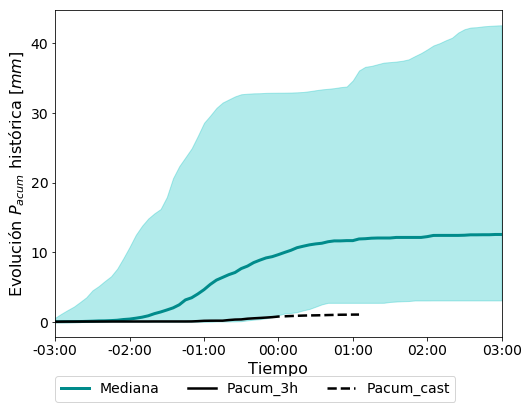

In [244]:
fig=pl.figure(figsize=(8,6))
ax=fig.add_subplot(111)
# pl.plot(mean,color='k',label='Media')
# for p,i in enumerate(Gs_ni.index):
#     ax.plot(ev_evolucion[str(i)] ,color='lightgray')
ax.fill_between(np.arange(evolP1.size),evolP1,evolP99, color = 'c', alpha = 0.3)
# ax.plot(evolP1,color='darkcyan',label='$P_{1}$',lw=3)#,ls='--'
# ax.plot(evolP99,color='darkcyan',label='$P_{99}$',lw=3)
ax.plot(evolP50,color='darkcyan',label='Mediana',lw=3) #'yeloowgreen.
ax.plot(np.arange(0,Pmean.size),evolObs[:Pmean.size].values,c='k',lw=2.5,label='Pacum_3h')
ax.plot(np.arange(Pmean.size,Pmean.size+Pcastmean_n.size),evolObs[Pmean.size:].values,c='k',lw=2.5,ls='--',label='Pacum_cast')
# # ax.axvline(36,0,10,color='k',ls='--')
# pl.scatter(45,nb/100.0,c='crimson',marker='*',s=150,label=u'Nmáx30')
ax.set_ylabel(u'Evolución $P_{acum}$ histórica $[mm]$', size= 16)
ax.set_xlabel('Tiempo', size= 16)
ax.tick_params(labelsize=14)
ax.set_xticks(np.arange(0,73,12))
ax.set_xticklabels(rng1)
ax.set_xlim(0,72)
# # ax.grid()
ax.legend(fontsize=14,loc=(0.,-0.2),ncol=3)

#### Acumulados

In [257]:
#Historicos
acum10days=[]
for date in Gs_ni.index:
    fi=date - pd.Timedelta('10 days')
    ff=date
    acum10days.append(PmeanH[fi:ff].sum())
#actual
fi=Pmean.index[-1] - pd.Timedelta('10 days')
ff=Pmean.index[-1]

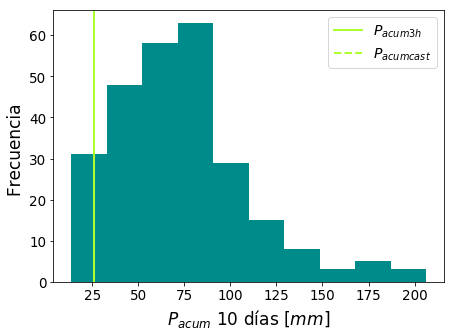

In [271]:
fig=pl.figure(figsize=(7,5))
ax=fig.add_subplot(111)
pl.hist(acum10days,color='darkcyan')
pl.axvline(Pmean[fi:ff].sum(),c='greenyellow',lw=2,label='$P_{acum3h}$')
pl.axvline(Pobs_plus.sum(),c='greenyellow',lw=2,label=u'$P_{acumcast}$',ls='--')
ax.set_ylabel('Frecuencia ', size= 17)
ax.set_xlabel(u'$P_{acum}$ 10 días $[mm]$', size= 17)
ax.tick_params(labelsize=13.5)
ax.legend(fontsize=14)

### Radar

Se cargan los mapas acumulados de los eventos.

In [280]:
mapacum_R=pd.read_csv('/media/nicolas/Home/Jupyter/Soraya/git/Academia/Art-Lluvia/data/CamposEvRadar_5min_2013-2017.csv')

#### Distribución de la lluvia respecto a la salida.

In [342]:
#grupos
meanval_group=[]
Grup = np.zeros(cu.ncells)
for c,i in enumerate(np.linspace(1,cu.ncells+1, 50)):
    Grup[cu.structure[0]>i] = c+1
groups=np.unique(Grup)

for date in Gs_ni.index:
    try:
        evento=mapacum_R[str(date)]
        toshow=[]
        for group in groups:
            posgroup=np.where(Grup==group)[0]
            toshow.append(evento[posgroup].mean())
        meanval_group.append(toshow)
    except:
        pass

In [349]:
print len(meanval_group)
print Gs_ni.index.size

209
263


In [410]:
meanval_gr=pd.DataFrame(meanval_group)
meanvalP50=meanval_gr.quantile(0.5)
meanvalP99=meanval_gr.quantile(0.99)
meanvalP10=meanval_gr.quantile(0.1)

(0, 49)

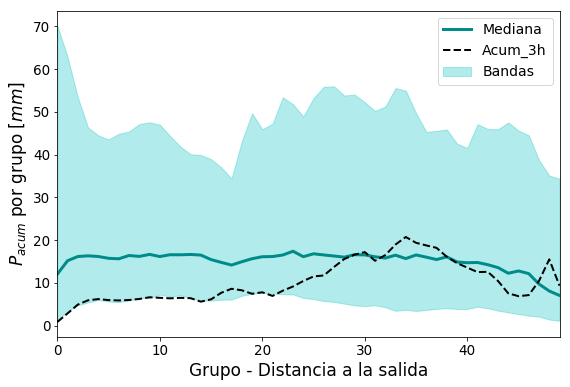

In [412]:
fig=pl.figure(figsize=(9,6))
ax=fig.add_subplot(111)
# pl.bar(groups,toshow,color='darkcyan')
ax.fill_between(np.arange(meanvalP10.size),meanvalP10,meanvalP99, color = 'c', alpha = 0.3,label='Bandas')
pl.plot(meanvalP50,c='darkcyan',lw=3,label='Mediana')
pl.plot(toshow,c='k',lw=2,label='Acum_3h',ls='--')
ax.set_ylabel('$P_{acum}$ por grupo $[mm]$', size= 17)
ax.set_xlabel(u'Grupo - Distancia a la salida', size= 17)
ax.tick_params(labelsize=13.5)
ax.legend(fontsize=14)
ax.set_xlim(0,49)

Donde estan los grupos

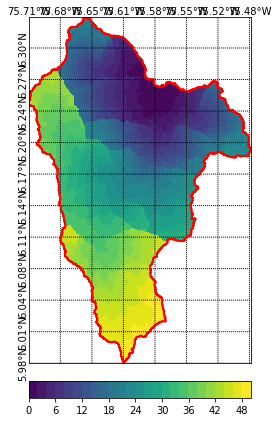

(<mpl_toolkits.basemap.Basemap at 0x7f487eed4dd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f487efd3250>)

In [399]:
cu.Plot_basin(Grup)